## Long short-term memory

*Эпоха* - это **весь** датасет обученный один раз: forwarding и back propagation. Количество эпох зависит от данных, т.е. нельзя в точности сказать что для такой-то задачи нужно вот столько-то эпох. Слишком много эпох вызовет переобучение, слишком мало может вызвать недообучение.

*Батч* - это часть датасета, т.е. весь датасет можно разбить на батчи какого-то размера. Количество батчей равняется количеству итераций в эпохе, и если посмотреть с другой стороны, то количество итерации - это количество батчей для обучения одной эпохи.

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from metrics import mar, far, f1_score

In [55]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Process data

In [90]:
df = pd.read_csv("./data/anomaly-free/anomaly-free.csv", 
                 sep=";", parse_dates=True, index_col="datetime")

df.sort_index(inplace=True)
df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-02-08 13:30:47,0.202394,0.275154,2.16975,0.382638,90.6454,26.8508,238.852,122.664
2020-02-08 13:30:48,0.203153,0.277857,2.07999,-0.273216,90.7978,26.8639,227.943,122.338
2020-02-08 13:30:50,0.202054,0.275790,2.52577,0.382638,90.7730,26.8603,223.486,121.338
2020-02-08 13:30:51,0.203595,0.278101,2.49742,0.054711,90.8424,26.8616,244.904,121.664
2020-02-08 13:30:52,0.201889,0.276363,2.29194,0.710565,90.6664,26.8603,239.196,122.000


In [91]:
SS = StandardScaler()
x_train = np.array(SS.fit_transform(df))

In [92]:
TIME_STEPS = 144

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

x_train = create_sequences(x_train)
print("Training input shape: ", x_train.shape)

Training input shape:  (9262, 144, 8)


### Make model

In [93]:
model = Sequential()

model.add(LSTM(units=100, activation='tanh', return_sequences=True, 
               input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(Dropout(rate=0.2))
model.add(Dense(units=1, activation="sigmoid"))

model.compile(optimizer='adam', loss='mse')

### Fitting

In [94]:
import keras

In [95]:
y_train = np.zeros(x_train.shape[0])
history = model.fit(x_train, y_train, epochs=1, batch_size=47, 
                    validation_split=0.1, 
                    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],)

178/178 [==============================] - 106s 555ms/step - loss: 0.0146 - val_loss: 0.0030


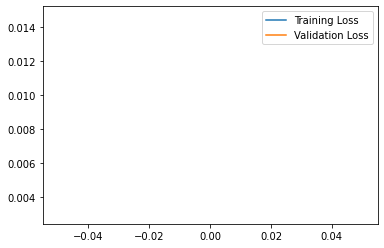

In [100]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

### Make predictions

In [101]:
df = pd.read_csv("./data/valve1/6.csv", sep=";", parse_dates=True, index_col="datetime")
df = df.sort_index()

y_test = np.array(df["anomaly"].astype(int))
df.drop(["anomaly", "changepoint"], inplace=True, axis=1)

x_test = np.array(SS.transform(df))

In [102]:
x_test = create_sequences(x_test)
print("Training input shape: ", x_test.shape)

Training input shape:  (1011, 144, 8)


In [103]:
y_pred = model.predict(x_test)

In [106]:
pd.Series(y_pred.reshape(-1)).describe()

count    145584.000000
mean          0.198943
std           0.014286
min           0.178199
25%           0.189865
50%           0.196402
75%           0.205615
max           0.332607
dtype: float64

In [36]:
y_pred = np.mean(y_pred, axis=1).flatten()

In [37]:
y_pred.sum()

0.0

In [13]:
y_pred = (model.predict(x_test) > 0.5).astype(int)

print(f"""F1 = {f1_score(y_test, y_pred)}
FAR = {far(y_test, y_pred)}
MAR = {mar(y_test, y_pred)}""")

F1 = 0.0
FAR = 0.0
MAR = 1.0


In [14]:
y_pred[0]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

### Vizualization

ValueError: Data must be 1-dimensional

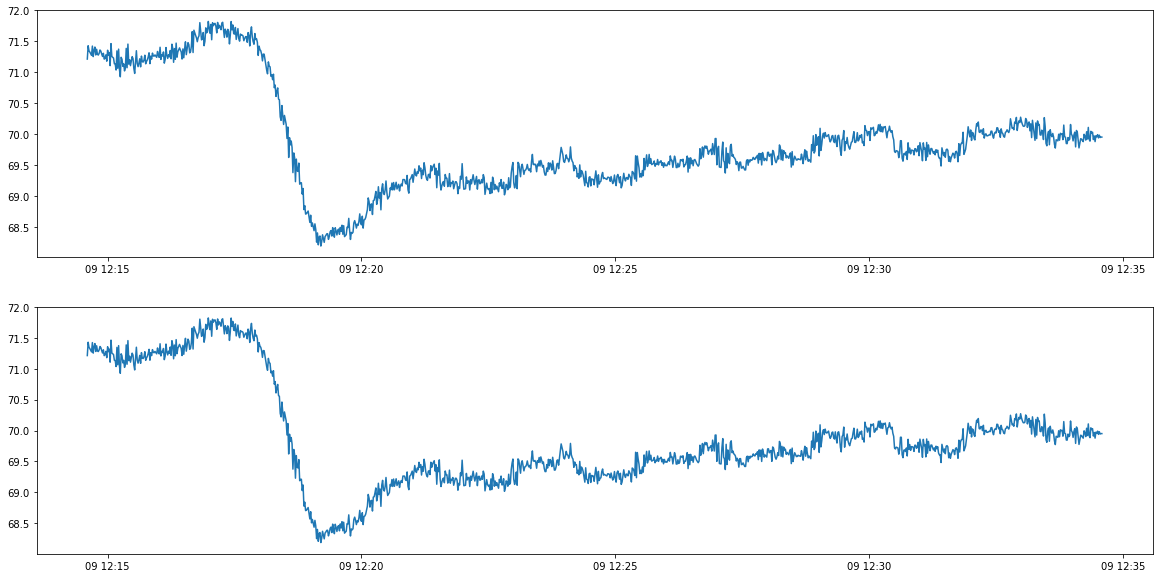

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(y_pred)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(df_test.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(y_test)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df_test.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [ ]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [ ]:
df_small_noise

In [ ]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

In [ ]:
df_training_value

In [ ]:
np.stack?

In [ ]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)
